In [2]:
from google.colab import files
uploaded = files.upload()  # Choose your downloaded .zip file


Saving archive.zip to archive.zip


In [3]:
import zipfile
import os

zip_path = list(uploaded.keys())[0]  # automatically gets the uploaded file name

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')  # extracts to a folder named dataset

print("Files extracted to:", os.listdir('dataset'))


Files extracted to: ['Fake.csv', 'True.csv']


In [4]:
import pandas as pd

fake_df = pd.read_csv("dataset/Fake.csv")
true_df = pd.read_csv("dataset/True.csv")

# Add labels
fake_df["label"] = 1  # 1 = fake
true_df["label"] = 0  # 0 = real

# Combine and shuffle
data = pd.concat([fake_df, true_df], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)

# Merge title + text
data["text"] = data["title"] + " " + data["text"]
data = data[["text", "label"]]

print(data.head())
print("Total samples:", len(data))


                                                text  label
0  Senators on defensive over all-male healthcare...      0
1   Watch This Democratic Congressman OBLITERATE ...      1
2  DONALD TRUMP STRIKES BACK: Reminds American Vo...      1
3  [VIDEO] GAY ACTRESS TRIES TO AMBUSH TED CRUZ A...      1
4  EU preaches tough love for impatient Ukraine B...      0
Total samples: 44898


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
vocab_size = 10000      # number of unique words to keep
max_len = 200           # max sequence length

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    data["text"], data["label"], test_size=0.2, random_state=42
)

# Tokenize text
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

print("Training data shape:", X_train_pad.shape)
print("Testing data shape:", X_test_pad.shape)


Training data shape: (35918, 200)
Testing data shape: (8980, 200)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
print(lstm_model.summary())

# Train
history_lstm = lstm_model.fit(X_train_pad, y_train, epochs=3, batch_size=64, validation_split=0.2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 320s 699ms/step - accuracy: 0.7682 - loss: 0.4832 - val_accuracy: 0.9016 - val_loss: 0.2988
Epoch 2/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 309s 689ms/step - accuracy: 0.9037 - loss: 0.2655 - val_accuracy: 0.7771 - val_loss: 0.4864
Epoch 3/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 304s 678ms/step - accuracy: 0.8438 - loss: 0.3754 - val_accuracy: 0.9482 - val_loss: 0.1529


In [7]:
from tensorflow.keras.layers import Bidirectional

# BiLSTM Model
bilstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])

bilstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
print(bilstm_model.summary())

# Train
history_bilstm = bilstm_model.fit(X_train_pad, y_train, epochs=3, batch_size=64, validation_split=0.2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 610s 1s/step - accuracy: 0.9290 - loss: 0.1581 - val_accuracy: 0.9990 - val_loss: 0.0051
Epoch 2/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 634s 1s/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 0.9987 - val_loss: 0.0054
Epoch 3/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.9999 - loss: 9.8211e-04 - val_accuracy: 0.9990 - val_loss: 0.0056


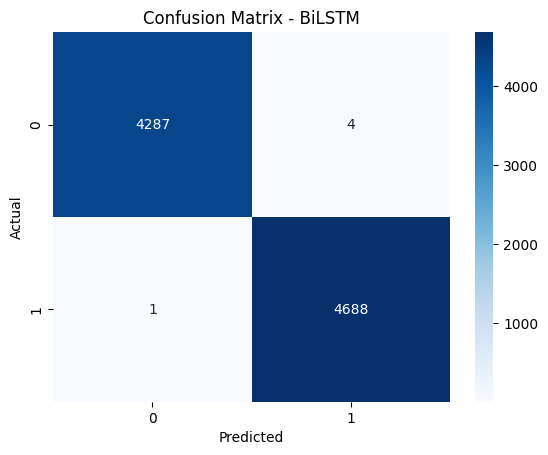

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_bilstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - BiLSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [8]:
from sklearn.metrics import classification_report, accuracy_score

# Predictions
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")
y_pred_bilstm = (bilstm_model.predict(X_test_pad) > 0.5).astype("int32")

# Metrics
print("LSTM Model Performance:")
print(classification_report(y_test, y_pred_lstm))
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))

print("\nBiLSTM Model Performance:")
print(classification_report(y_test, y_pred_bilstm))
print("Accuracy:", accuracy_score(y_test, y_pred_bilstm))


281/281 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 46s 162ms/step
LSTM Model Performance:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4291
           1       0.95      0.95      0.95      4689

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980

Accuracy: 0.9442093541202673

BiLSTM Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4291
           1       1.00      1.00      1.00      4689

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Accuracy: 0.9994432071269488


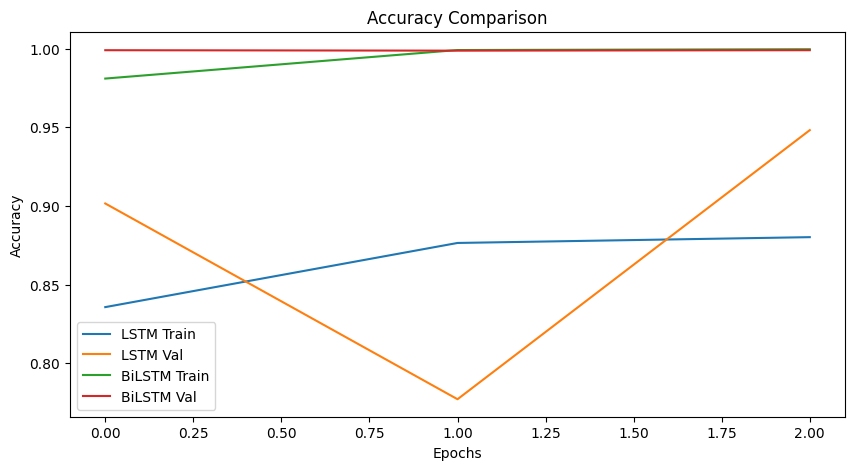

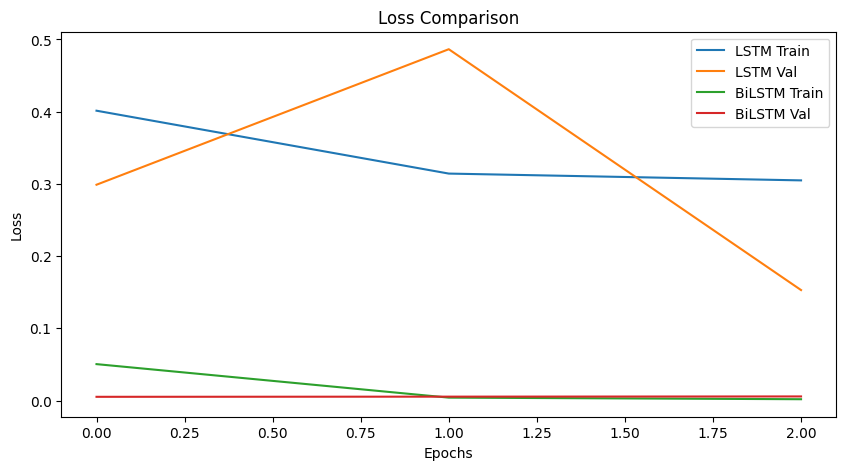

In [9]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history_lstm.history['accuracy'], label='LSTM Train')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val')
plt.plot(history_bilstm.history['accuracy'], label='BiLSTM Train')
plt.plot(history_bilstm.history['val_accuracy'], label='BiLSTM Val')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(history_lstm.history['loss'], label='LSTM Train')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val')
plt.plot(history_bilstm.history['loss'], label='BiLSTM Train')
plt.plot(history_bilstm.history['val_loss'], label='BiLSTM Val')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
